# Large Language Model Visual Analytic Chat Comparison

This is a notebook that explores how different large language models produce visualizations in response to user utterances.

We use conversations from a previously published study to evaluate the model's behavior. The conversations in this prior study were broken up into chunks. Each chunk represents a sequence of utterance that are intended to modify a data visualization. Thus the conversational context needs to be maintained within a chunk, but can be different for each chunk. 

**Setup**

To run this notebook you'll need to set up a `.env` file that contains an OpenAI and Hugging Face API Keys, as well as links to different urls and assistant IDs. That's because accessing all of these tools cost money (yes even the open source ones) and so you will need to set that up. See `.env_example` for an example of what this file should look like.

**Streamlit App**

The results of this notebook are compiled into a streamlit application. To run this application, run `pipenv run app` in the terminal. A version of this application is also hosted here: TBD

**Notes**
This version of the notebook is a scratch pad the exposes the details of working through the library calls on  `llm_comparison`. To cut to the chase and just see the analysis and results, check out the notebook entitled `llm_response_with_library.ipynb`.

In [1]:
#data handling
import pandas as pd

#chatgpt
from openai import OpenAI

#hf
from transformers import AutoTokenizer
from huggingface_hub import InferenceClient
from transformers import pipeline


#prompts and processing
from chat2Vis import format_response,get_primer

#image handling
import io
import base64
from IPython import display
import matplotlib.pyplot as plt


#misc
from dotenv import dotenv_values
import concurrent.futures
import hashlib
from random import randint
from time import sleep


/Users/ana.crisan/.local/share/virtualenvs/llm_comparison-12X0hGMe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chat Set Up

In [2]:
#useful because your don't need to read in the CSV data, makes things a little easier
df = pd.read_csv('workspace/Titanic-Dataset.csv')

For this example, we'll use the primer prompts from the [Chat2Vis repository](https://github.com/frog-land/Chat2VIS_Streamlit). This just gives a base line to start off of.

In [3]:
primer_desc, primer_code = get_primer(df,'./workspace/Titanic-Dataset.csv')

chat = [
  {"role": "system", "content": primer_desc}
]
chat

[{'role': 'system',
  'content': "Use a dataframe called df from './workspace/Titanic-Dataset.csv' with columns 'PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'. \nThe column 'PassengerId' is type int64 and contains numeric values. \nThe column 'Survived' is type int64 and contains numeric values. \nThe column 'Pclass' is type int64 and contains numeric values. \nThe column 'Sex' has categorical values 'male','female'. \nThe column 'Age' is type float64 and contains numeric values. \nThe column 'SibSp' is type int64 and contains numeric values. \nThe column 'Parch' is type int64 and contains numeric values. \nThe column 'Fare' is type float64 and contains numeric values. \nThe column 'Embarked' has categorical values 'S','C','Q','nan'. \nLabel the x and y axes appropriately.\nAdd a title. Set the fig suptitle as empty.{}\nUsing Python version 3.9.12, create a script, the script should only include code, no comments, using the dataf

# LLM Setup

In [4]:
#basic test converations
convo_hist = chat
convo_hist.append({'role':"user", "content":"show chart of total number of people surviving vs not surviving"})

In [35]:
convo_hist

[{'role': 'system',
  'content': "Use a dataframe called df from './workspace/Titanic-Dataset.csv' with columns 'PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'. \nThe column 'PassengerId' is type int64 and contains numeric values. \nThe column 'Survived' is type int64 and contains numeric values. \nThe column 'Pclass' is type int64 and contains numeric values. \nThe column 'Sex' has categorical values 'male','female'. \nThe column 'Age' is type float64 and contains numeric values. \nThe column 'SibSp' is type int64 and contains numeric values. \nThe column 'Parch' is type int64 and contains numeric values. \nThe column 'Fare' is type float64 and contains numeric values. \nThe column 'Embarked' has categorical values 'S','C','Q','nan'. \nLabel the x and y axes appropriately.\nAdd a title. Set the fig suptitle as empty.{}\nUsing Python version 3.9.12, create a script, the script should only include code, no comments, using the dataf

## API Access

This code requires that you have:

* Set up your own OpenAI and Hugging Face Tokens 
* Set up the [hugging face inference endpoint](https://huggingface.co/blog/inference-endpoints-llm) and have a url that you point it to

If you have neither of those, this code will not run. You can run and set up Code LLama on your own machines if you want, it just takes a lot of compute to set up and run the Code LLama 34b parameter model - the inference endpoints might be best. That endpoint cost $4.50/hr currently, you can run the 7 billion parameter model for less (and even a high-end laptop), but the results aren't as good.


In [5]:
config = dotenv_values(".env")

### ChatGPT

In [37]:
client = OpenAI(
    api_key=config['OPENAI_API_KEY']
)

def call_openai(model='gpt-3.5-turbo', messages=None):
    completion = client.chat.completions.create(
        model = model,
        messages = messages
    )
    return(completion)

In [8]:
#test call
gpt_ans= call_openai(messages=convo_hist)
gpt_ans = gpt_ans.choices[0].message.content

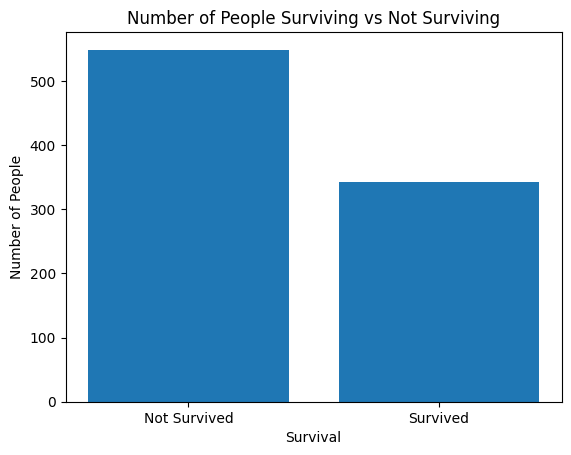

In [9]:
exec(gpt_ans)

#### ChatGPT Assistants API test

**This is a new feature which can explicitly use code interpreter, relative to the standard ChatGPT API.**


You only need to do this once, afterwards, you just provide the assistant id, which can be stored in a .env file

``` Python
file = client.files.create(
  file=open("./workspace/Titanic-Dataset.csv", "rb"),
  purpose='assistants'
)


assistant = client.beta.assistants.create(
    name="VA Chat",
    instructions="You are a visual analytics assistant. You will create data visualizations that generate visualizations based on user input.",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-1106-preview",
    file_ids=[file.id]
)
```

In [38]:
#create a slightly modified primer description for the assistant
primer_desc_mod= f"Using Python version 3.9.12, create and return script responding to the user's query. The script should only include code, no comments, using a dataframe called df to graph the following"

In [39]:
#initialze conversation
thread = client.beta.threads.create()
a_id = config['ASSISTANT_ID']

In [40]:

def add_assistant_msg(message,thread_id):
    #assumes that message is a dictionary containing the role and content
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role=message['role'],
        content=message['content']
    )
    return(message)

def get_run_steps(thread_id,run_id):
    run_steps = client.beta.threads.runs.steps.list(
        thread_id=thread_id,
        run_id=run_id
    )
    code=''
    for step in run_steps.data[::-1]:
        try:
            s = step.step_details.tool_calls[0].code_interpreter.input
           
            s = s.replace(config['OAI_FILE'],'./workspace/Titanic-Dataset.csv')
            code = code + "\n\n" + s
        except:
            pass
    return code

def run_openai_assistant(message,thread_id,a_id,primer_desc_mod,code_only=True):
  
    #add new message to thread
    message = add_assistant_msg(message,thread_id)

    #create the run
    run = client.beta.threads.runs.create(
        thread_id=thread_id,
        assistant_id=a_id,
        instructions=primer_desc_mod
        )

    #get the response
    complete = False
    while not complete:
        run = client.beta.threads.runs.retrieve(
        thread_id=thread_id,
        run_id=run.id
        )
        if run.status == "completed":
            complete = True
        elif run.status not in ["in_progress","queued"]:
            raise Exception("Response failed to return")       
        else:
            sleep(5)

    #now that it is complete, get the message responses:
    messages = client.beta.threads.messages.list(thread_id=thread_id)  

    #code interpreter will provide an image file (latest file is always index 0)
    try:
        image=client.files.content(messages.data[0].content[0].image_file.file_id) 
    except:
        #if there is no image, return the messages
        #the most recent message is just text
        return messages, run 

    if code_only:
        return get_run_steps(thread_id,run.id)
    
    #return the message history and the content
    return messages, image.content, run


In [41]:
message = {
    "role": "user",
    "content": "show chart of total number of people surviving vs not surviving"
}
#messages, image, run= run_openai_assistant(message,thread.id,a_id,primer_desc_mod,code_only=False)
code = run_openai_assistant(message,thread.id,a_id,primer_desc_mod)

In [42]:
exec(code)

"\n\nimport pandas as pd\r\nimport matplotlib.pyplot as plt\r\n\r\n# Load the dataframe\r\ndf = pd.read_csv('./workspace/Titanic-Dataset.csv')\r\n\r\n# Check for a column that indicates survival, typically it is called 'Survived'\r\n# where 1 indicates survival and 0 indicates not surviving\r\n# df.head() is used to see the first few rows of the dataframe to identify the correct column\r\ndf.head()\n\n# The 'Survived' column is present and indicates survival.\r\n\r\n# Calculate the total number of people surviving vs not surviving\r\nsurvival_counts = df['Survived'].value_counts()\r\n\r\n# Plot the chart\r\nsurvival_counts.plot(kind='bar')\r\nplt.title('Total Number of People Surviving vs Not Surviving')\r\nplt.xlabel('Survival Status (0 = Not Survived, 1 = Survived)')\r\nplt.ylabel('Number of People')\r\nplt.xticks(rotation=0)\r\nplt.show()"

**Test: Continuing the conversation**

In [15]:
#adding a new conversation item
message = {
    "role": "user",
    "content": "show age bins"
}

Below is a good example that the assistant creates a totally new image, and does not add the context for the prior chart (e.g. survival) to the new chart (e.g. age bins)


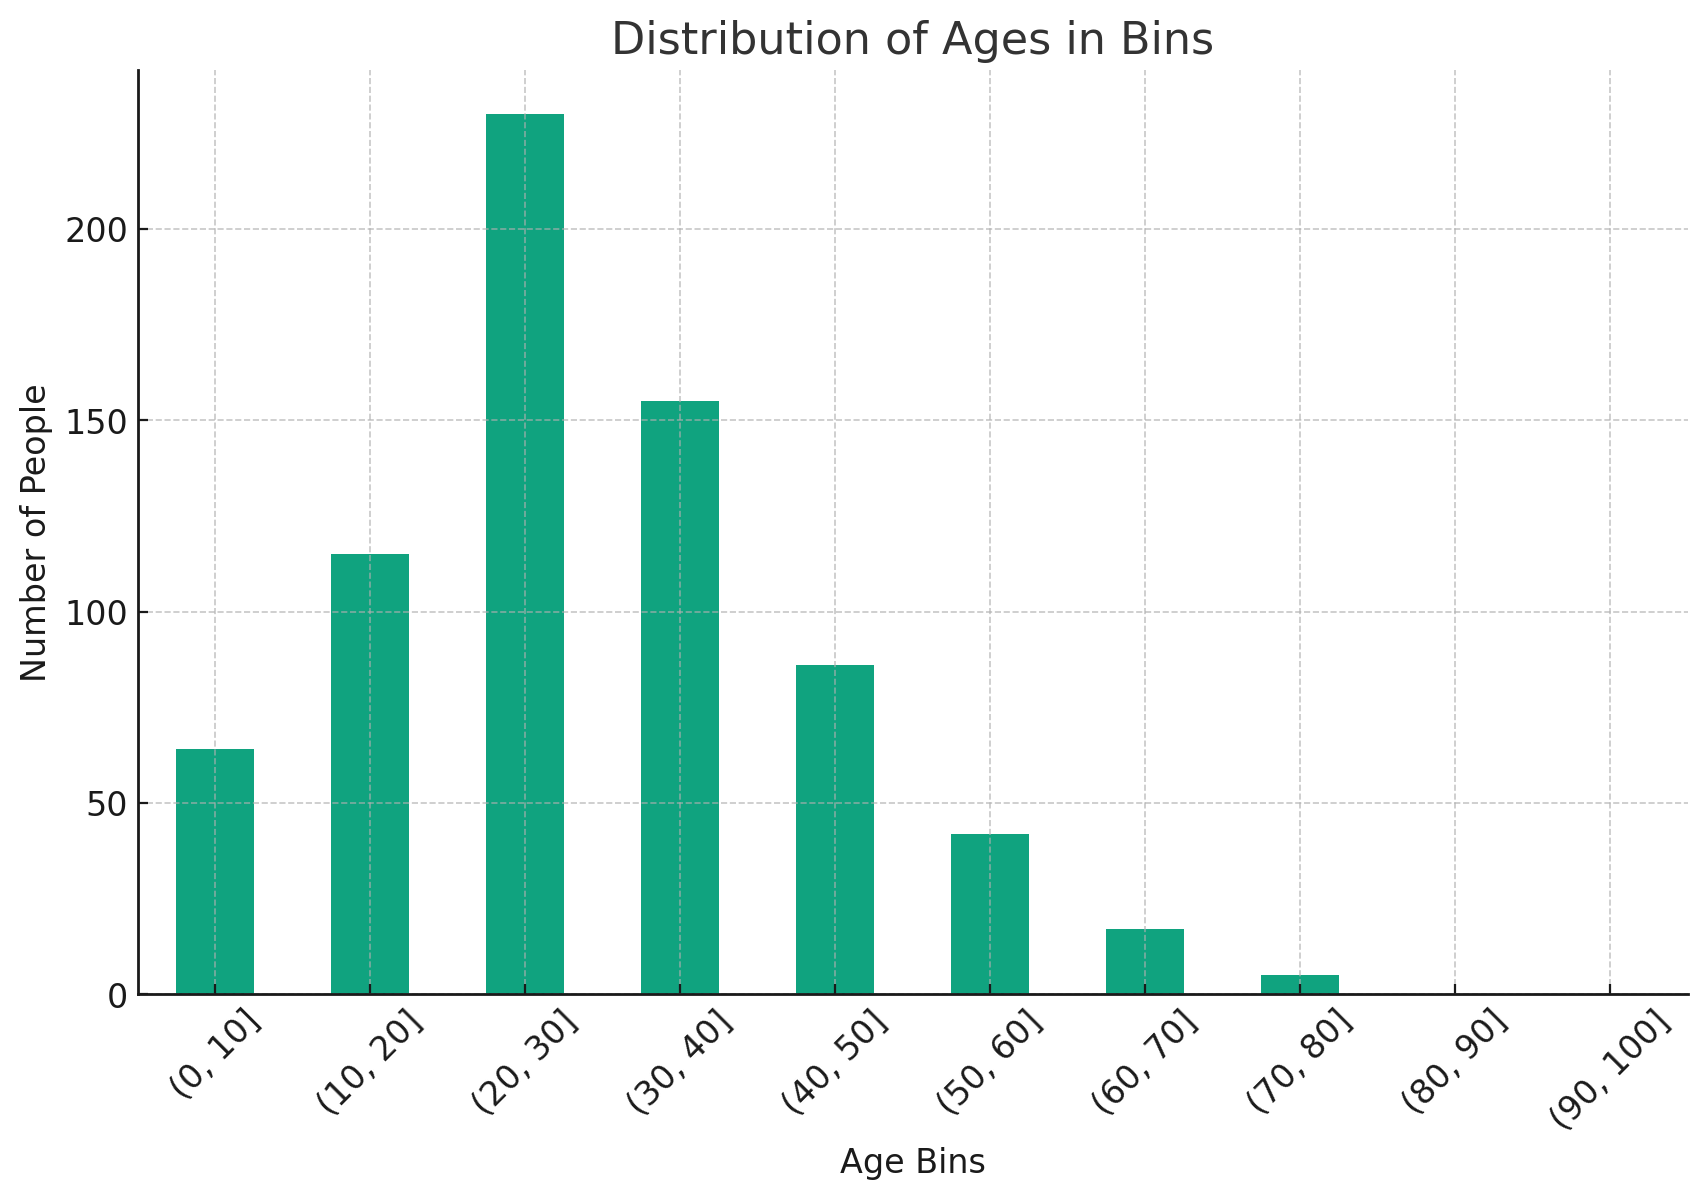

In [16]:
messages, image, run = run_openai_assistant(message,thread.id,a_id,primer_desc_mod,code_only=False)
code = get_run_steps(thread.id,run.id)
display.Image(image,width = 250, height = 250)

In [17]:
#confirming that all messages were added to the chat (they are)
messages.data

[ThreadMessage(id='msg_C8zjWm0PBf1bQ0ny46XTaEsa', assistant_id='asst_XLp3PQR3bQdaI5nnRVfYsTHf', content=[MessageContentImageFile(image_file=ImageFile(file_id='file-5DJiUBOQtVGXb1pdQI0jv3k3'), type='image_file'), MessageContentText(text=Text(annotations=[], value='Here is the chart showing the distribution of ages in specified bins.'), type='text')], created_at=1702318118, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_OWc82V8icGGzEOQZm4ekOXOB', thread_id='thread_gTDTrq8jYCda4tLH7tYauNqR'),
 ThreadMessage(id='msg_4qo1h8H5Ggp3wBeTREseSiej', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='show age bins'), type='text')], created_at=1702318103, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_gTDTrq8jYCda4tLH7tYauNqR'),
 ThreadMessage(id='msg_QH3lEHTn5ANHIp7NrQLpUxDc', assistant_id='asst_XLp3PQR3bQdaI5nnRVfYsTHf', content=[MessageContentImageFile(image_file=ImageFile(file_id='file

**To give open ai an honest shot, lets see if it works with a modified primer telling it what to do**

In [18]:
primer_desc_mod_content= f"Using Python version 3.9.12, create and return visualization responding to the user's query. Create this visualization using a dataframe called df to graph the following. Unless the user enters a phrase like `start over', `rest' or `clear' retain the context prior the prior messages when updating the visualization. Otherwise, start a brand new data visualization."

#initialze conversation
thread = client.beta.threads.create()
a_id = config['ASSISTANT_ID']

#... message one
message = {
    "role": "user",
    "content": "show chart of total number of people surviving vs not surviving"
}
messages, image_1= run_openai_assistant(message,thread.id,a_id,primer_desc_mod)

#... message two
message = {
    "role": "user",
    "content": "show age bins"
}

messages, image_two,run= run_openai_assistant(message,thread.id,a_id,primer_desc_mod,code_only=False)
display.Image(image_two,width = 250, height = 250)

ValueError: too many values to unpack (expected 2)

Even with this modified prompt the open ai assistant DOES NOT include the survival variable (e.g., it does not retain the context of the prior chart). **This is using the latest GPT-4 model**

### Code LLAMA

In [6]:
def setup_codellama(model_size="7B"):
    # HF Inference Endpoints parameter
    endpoint_url = config['CL_7B']

    if model_size == "13B":
        endpoint_url = config['CL_13B']


    # Streaming Client
    # ** warning - do no call the hf client, 'client' or it will inferfere with the openai client
    hf_inf = InferenceClient(endpoint_url, token=config['HF_API_KEY'])

    # generation parameter
    gen_kwargs = dict(
        max_new_tokens=512,
        top_k=30,
        top_p=0.9,
        temperature=0.2,
        repetition_penalty=1.02,
    )

    return hf_inf, gen_kwargs

def format_prompt(convo,primer = None):

    if(primer is not None):
        #need to remind code llama to write out
        #code each time :/
        idx = len(convo)-1 #appy to most recent utterance
        convo[idx]['content'] = primer + convo[idx]['content']
        print(convo)
        
    #preping the prompt for Code LLama
    tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-Instruct-hf",token=config['HF_API_KEY'])
    tokenizer.use_default_system_prompt = False
    prompt = tokenizer.apply_chat_template(convo, tokenize=False)

    return prompt

def call_codellama(convo,hf_inf,gen_kwargs,primer=None):
    #calling Code LLama
    prompt = format_prompt(convo,primer)
    stream = hf_inf.text_generation(prompt, stream=False, details=True, **gen_kwargs)
    response = primer_code + format_response(stream.generated_text.strip())

    #try execute the response a maximum of twice if the code doesn't run
    '''
    try:
        ans=exec(response)
    except:
        if attempt ==3:
            response = "ERROR: FAILED TO EXECUTE CODE"
        else:
            attempt+=1
            response = call_codellama(convo,client,gen_kwargs,attempt)
    '''
    
    return response

In [20]:
hf_inf, gen_kwargs = setup_codellama(model_size="13B")
cl_ans = call_codellama(convo_hist,hf_inf,gen_kwargs,primer_desc)

[{'role': 'system', 'content': "Use a dataframe called df from './workspace/Titanic-Dataset.csv' with columns 'PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'. \nThe column 'PassengerId' is type int64 and contains numeric values. \nThe column 'Survived' is type int64 and contains numeric values. \nThe column 'Pclass' is type int64 and contains numeric values. \nThe column 'Sex' has categorical values 'male','female'. \nThe column 'Age' is type float64 and contains numeric values. \nThe column 'SibSp' is type int64 and contains numeric values. \nThe column 'Parch' is type int64 and contains numeric values. \nThe column 'Fare' is type float64 and contains numeric values. \nThe column 'Embarked' has categorical values 'S','C','Q','nan'. \nLabel the x and y axes appropriately.\nAdd a title. Set the fig suptitle as empty.{}\nUsing Python version 3.9.12, create a script, the script should only include code, no comments, using the datafra

TypeError: bar() missing 1 required positional argument: 'height'

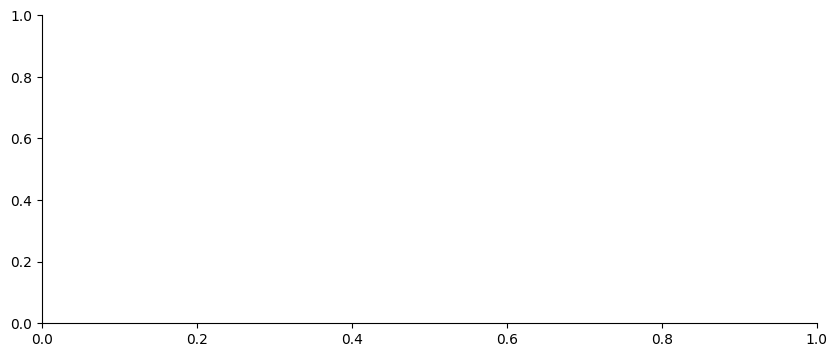

In [22]:
exec(cl_ans)

In [11]:
#plot the answer
# Note: the 7B Code LLama model is usually very wrong - its good for testing, but not as good for actual results
import re
code_matches = re.findall(r'```\n(.*?)\n```', cl_ans, re.DOTALL)


KeyError: 'Not Survived'

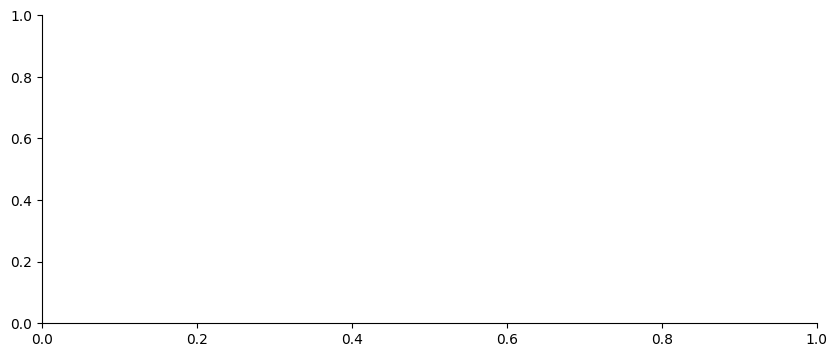

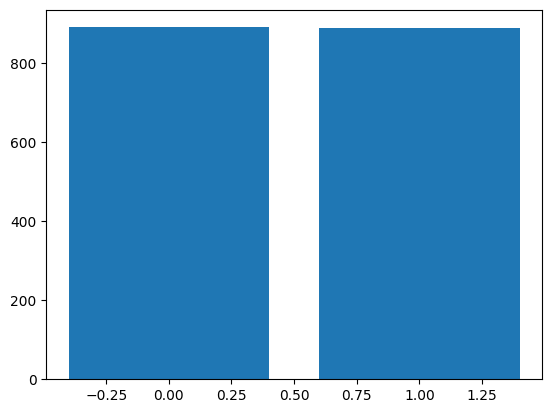

In [16]:
exec(primer_code + code_matches[0])

# All Conversations

In [22]:
# Loading conversations from Tory and Setlur
convos = pd.read_csv('workspace/utterances.csv')

In [23]:
def get_hash(x):
    rn = str(randint(0, 100))
    return(hashlib.md5(f"{x['PID']}-{x['Utterance']}-{rn}".encode('utf-8')).hexdigest())


pids = convos['PID'].unique()

convos['utt_id']=convos.apply(lambda x: get_hash(x), axis=1)
convos[convos['PID'] == 'P03']

,PID,Context Shift,Anaphoric Reference,Utterance,Chunk,utt_id
0,P03,Explicit,No,How many people survived?,1,f482dbace955985d4d5bb67e3e386a9b
1,P03,Explicit,No,Show age bins,1,5f492fc56dd0d53f9e73a3d30a2cff2d
2,P03,Explicit,No,What are the top 5 age bins that survived?,1,0fe3d56ccad289894fcd4b95911fca20
3,P03,Explicit,No,color survived by class,1,577f376812f632077d5bb94b1631e1dc
4,P03,Explicit,No,show only female,1,dc2f13dd14948b56dfaf685cf2330d53
5,P03,Explicit,No,show only male,1,ca8915ca17cfc8fd4e0f2718c3131a4f
6,P03,Explicit,No,start over,1,b2af9ee7af1f565d41871519075c5b0f
7,P03,Explicit,No,show survived colored by parents on board,2,c3684c12385317112486bfd319e35885
8,P03,Explicit,No,color sibilings,2,31f260e1ac5f1984058ff43cbfcc5dbc
9,P03,Explicit,No,start over,2,30a248eee529659808011597901c2635


In [24]:
class analytic_conversation:
    def __init__(self,pid,history=[]):
        self.pid = pid
        self.history = history
    
    def add_utterance(self,utterance,utt_id):
        utterance = [{'role':'user','model': '', 'content':utterance,'utt_id':utt_id}]
        self.history+= utterance

    
    def add_response(self,utt_id,responses):
        '''
        responses should be a dictionary object where:
        * each key is a model containing
        * the code it executed 
        '''        
        assistant_resp = []

        for key in responses.keys():
            tmp = [{'role':'assistant','model': key, 'content':responses[key],'utt_id':utt_id}]
            assistant_resp +=tmp
            
        self.history+= assistant_resp
    
    def return_filtered_history(self, model_type=''):
        ''' return the chat history filtered by a specific model'''

        if model_type == '':
            return(self.history)
        
        filtered_conversation = []
        for item in self.history:
            if item['role'] in ['user','system']:
                filtered_conversation+=[{'role':item['role'],'content':item['content']}]
            elif item['role'] == 'assistant':
                if item['model'] == model_type:
                    filtered_conversation+=[{'role':item['role'],'content':item['content']}]

        return(filtered_conversation)
    
    def to_df(self):
        return(pd.DataFrame(self.history))
    
    def __repr__(self):
        return(f"Analytic Conversation for PID: {self.pid}")

**Example / Sanity Check : One Participant**

This goes through one participant, adding conversations one at a time to show how its done. This is a good sanity check to make sure that the code is working as expected.

In [ ]:
#run gpt and code-llama models, store the results
sys={"role": "system", "model":'',"content": primer_desc}

#filter conversation
pid='P03'
#initialze conversation - for each participant
tst_thread = client.beta.threads.create()

sub_convo = convos[convos['PID']==pid]
new_convo = analytic_conversation(pid,[sys])

#add a new utterance
new_convo.add_utterance(sub_convo.iloc[0]['Utterance'],sub_convo.iloc[0]['utt_id'])

#get model responses
with concurrent.futures.ThreadPoolExecutor() as executor:

    future1 = executor.submit(run_openai_assistant,{'role':'user', 'content':sub_convo.iloc[0]['Utterance']},tst_thread.id,a_id,primer_desc_mod)
    CI_ans=future1.result()

    future2 = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
    try:
        gpt_ans = future2.result().choices[0].message.content
    except:
        gpt_ans="FAILED TO RUN"

    future3 = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs,primer_desc)
    try:
        cl_ans = future3.result()
    except:
        cl_ans="FAILED TO RUN"
responses = {'CI':CI_ans,'gpt3':gpt_ans,'cl':cl_ans}
new_convo.add_response(sub_convo.iloc[1]['utt_id'],responses)


In [ ]:
#add responses
new_convo.add_response(sub_convo.iloc[0]['utt_id'],responses)
new_convo.history

In [ ]:
#get model responses WITH follow-up conversation
new_convo.add_utterance(sub_convo.iloc[1]['Utterance'],sub_convo.iloc[1]['utt_id'])

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(run_openai_assistant,{'role':'user', 'content':sub_convo.iloc[1]['Utterance']},tst_thread.id,a_id,primer_desc_mod)
    CI_ans=future1.result()

    future2 = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
    try:
        gpt_ans = future2.result().choices[0].message.content
    except:
        gpt_ans="FAILED TO RUN"

    future3 = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs,primer_desc)
    try:
        cl_ans = future3.result()
    except:
        cl_ans="FAILED TO RUN"

responses = {'CI':CI_ans,'gpt3':gpt_ans,'cl':cl_ans}
new_convo.add_response(sub_convo.iloc[1]['utt_id'],responses)

In [ ]:
new_convo.return_filtered_history('gpt3')

**ALL Participants**

In [26]:
#modifying the system command passed to GPT-3 and Code LLama, so that it matches what was provided to Code Interpreter
primer_mod = "You are an assistant helping a data scientist write code that produces a data visualization.  Using Python version 3.9.12, create and return visualization responding to the user's query with the data file provided to you. Create this visualization using a dataframe called df to graph the following. Unless the user enters a phrase like `start over', `rest' or `clear' retain the context prior the prior messages when updating the visualization. Otherwise, start a brand new data visualization"

In [27]:
#run gpt and code-llama models, store the results
sys={"role": "system", "model":'',"content": primer_mod + "\n" + primer_desc}

a_id = config['ASSISTANT_ID']

run_models = ['GPT-4','GPT-3']

#filter conversation
for pid in ['P03']:
    #count = 0;
    sub_convo = convos[convos['PID']==pid]
    new_convo = analytic_conversation(pid,[sys])

    #For Code Interpreter : initialze conversation - for each participant
    thread = client.beta.threads.create()

    grouped = sub_convo.groupby('Chunk')

    for chunk, group in grouped:
        for utt,utt_id in group[['Utterance','utt_id']].values.tolist():       
            #add new utterance
            new_convo.add_utterance(utt,utt_id)

            responses = {}
            #get language model results
            with concurrent.futures.ThreadPoolExecutor() as executor:
                    if 'GPT-4' in run_models:
                        future1 = executor.submit(run_openai_assistant,{'role':'user', 'content':utt},thread.id,a_id,primer_desc_mod)
                        CI_ans=future1.result()
                        
                        #when its a text response, modify what is returned
                        if type(CI_ans) == tuple:
                            try:
                                CI_ans = f"TEXT:{CI_ans[0].data[0].content[0].text.value}"
                            except:
                                print("Returned and image for some reason")
                                CI_ans == f"IMAGE:"

                        responses['CI']=CI_ans


                    if 'GPT-3' in run_models:
                        future2 = executor.submit(call_openai, 'gpt-3.5-turbo',new_convo.return_filtered_history('gpt3'))
                        try:
                            gpt_ans = future2.result().choices[0].message.content
                        except:
                            gpt_ans="FAILED TO RUN"

                        responses['gpt3']=gpt_ans

                    if 'CodeLlama' in run_models:
                        future3 = executor.submit(call_codellama, new_convo.return_filtered_history('cl'),hf_inf,gen_kwargs,primer_desc)
                        try:
                            cl_ans = future3.result()
                        except:
                            cl_ans="FAILED TO RUN"
                        
                        responses['cl']=cl_ans
                    

            #add responses to conversation history
            #responses = {'CI':CI_ans,'gpt3':gpt_ans,'cl':cl_ans}
            new_convo.add_response(utt_id,responses)
            sleep(10) #avoid over pinging the API

        #test breaker
        #count+=1
        #if count == 1:
        #    break

    all_df = pd.merge(sub_convo,new_convo.to_df(),on='utt_id',how='inner')
    all_df.to_pickle(f'workspace/convos/{pid}_analytic_convo.pkl')

AttributeError: 'MessageContentImageFile' object has no attribute 'text'

In [30]:
CI_ans[0].data[0].content[0]

MessageContentImageFile(image_file=ImageFile(file_id='file-DXimAYO0rMtC2NqsGH5ObMGk'), type='image_file')

In [28]:
all_df

NameError: name 'all_df' is not defined

# Hacking / Exploring Code

In [123]:
tmp = pd.read_pickle("workspace/convos/P03_analytic_convo.pkl")
tmp

,PID,Context Shift,Anaphoric Reference,Utterance,Chunk,utt_id,role,model,content
0,P03,Explicit,No,How many people survived?,1,64c84e39d2140a7fa0a1d7893ac0fbdc,user,,How many people survived?
1,P03,Explicit,No,How many people survived?,1,64c84e39d2140a7fa0a1d7893ac0fbdc,assistant,CI,"Based on the information in the dataset, 342 p..."
2,P03,Explicit,No,How many people survived?,1,64c84e39d2140a7fa0a1d7893ac0fbdc,assistant,gpt3,import pandas as pd\nimport matplotlib.pyplot ...
3,P03,Explicit,No,Show age bins,1,fc8e7896acfdbb98600bd03bd591983b,user,,Show age bins
4,P03,Explicit,No,Show age bins,1,fc8e7896acfdbb98600bd03bd591983b,assistant,CI,\n\nimport matplotlib.pyplot as plt\n\n# Assum...
5,P03,Explicit,No,Show age bins,1,fc8e7896acfdbb98600bd03bd591983b,assistant,gpt3,import pandas as pd\nimport matplotlib.pyplot ...
6,P03,Explicit,No,What are the top 5 age bins that survived?,1,e738c15b9738aaabb2bc491910536289,user,,What are the top 5 age bins that survived?
7,P03,Explicit,No,What are the top 5 age bins that survived?,1,e738c15b9738aaabb2bc491910536289,assistant,CI,The top 5 age bins with the most survivors are...
8,P03,Explicit,No,What are the top 5 age bins that survived?,1,e738c15b9738aaabb2bc491910536289,assistant,gpt3,import pandas as pd\nimport matplotlib.pyplot ...
9,P03,Explicit,No,color survived by class,1,e691c57a0105cb7804d61a4ac783b060,user,,color survived by class


<string>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 1      green
2       blue
3      green
8       blue
9       blue
       ...  
875     blue
879    green
880     blue
887     blue
889     blue
Name: Fare Bin, Length: 342, dtype: category
Categories (5, object): ['blue' < 'green' < 'red' < 'purple' < 'orange']

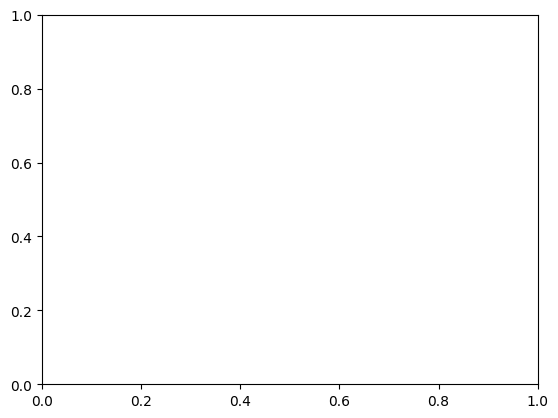

In [126]:
exec(tmp['content'][32])